In [53]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import load_model
from PIL import Image
import io

In [14]:
train_dir = '/home/ubuntu/CrowdSourcing_Projects/CSRNet-keras/data/Crowd Density Classification/train'
validation_dir = '/home/ubuntu/CrowdSourcing_Projects/CSRNet-keras/data/Crowd Density Classification/test'
image_size = 224

## Experiment 1: Freezing all layers - Same as Transfer Learning
Create the model

In [4]:
from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()











<keras.engine.input_layer.InputLayer object at 0x7f86fe9aceb8> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe9a4198> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe9a4438> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86fe9ce518> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe9cda58> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe166be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86fe16ca20> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe177940> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe179208> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe185588> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86fe182828> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe195320> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe195e48> False
<keras.layers.convolutional.Conv2D object at 0x7f86fea0f7f0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8

## Experiment 1
Train the model

Found 100 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/20
1/1 [==============================] - 17s 17s/step - loss: 0.0477 - acc: 0.9900 - val_loss: 4.2734 - val_acc: 0.5000
Epoch 2/20
1/1 [==============================] - 11s 11s/step - loss: 3.7820 - acc: 0.5000 - val_loss: 0.1757 - val_acc: 0.9286
Epoch 3/20
1/1 [==============================] - 9s 9s/step - loss: 0.1930 - acc: 0.9700 - val_loss: 2.3887e-04 - val_acc: 1.0000
Epoch 4/20
1/1 [==============================] - 10s 10s/step - loss: 0.0507 - acc: 0.9900 - val_loss: 4.9746e-04 - val_acc: 1.0000
Epoch 5/20
1/1 [==============================] - 9s 9s/step - loss: 0.0261 - acc: 0.9900 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 6/20
1/1 [==============================] - 9s 9s/step - loss: 0.0285 - acc: 0.9900 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 7/20
1/1 [==============================] - 9s 9s/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 8/20
1/1 [

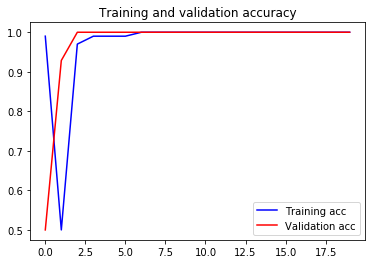

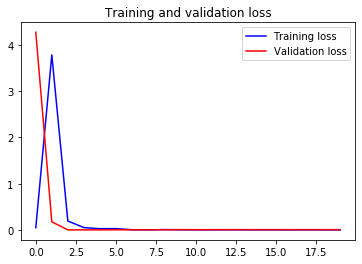

In [6]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the Model
model.save('all_freezed_2.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Experiment 1
Show the errors

In [7]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

Found 28 images belonging to 2 classes.
3/2 [================================] - 3s 1s/step
No of errors = 0/28


## Experiment 2 : Train Last 4 layers without data augmentation

In [8]:
from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.engine.input_layer.InputLayer object at 0x7f86fe10f240> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe10f0f0> False
<keras.layers.convolutional.Conv2D object at 0x7f86fe10f860> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86fe9ac860> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd50cd68> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd57ed30> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86fd51d3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd523b00> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd528c18> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd534a90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86fd5422e8> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd549a20> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd4ceb38> False
<keras.layers.convolutional.Conv2D object at 0x7f86fd4d59b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86fd4e3208>

## Experiment 2
Train the model

In [10]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 5

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the Model
model.save('last4_layers.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 100 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/20


ValueError: Error when checking target: expected dense_4 to have shape (2,) but got array with shape (1,)

## Experiment 2
Show the errors

Found 150 images belonging to 3 classes.
15/15 [==============================] - 0s     
No of errors = 9/150


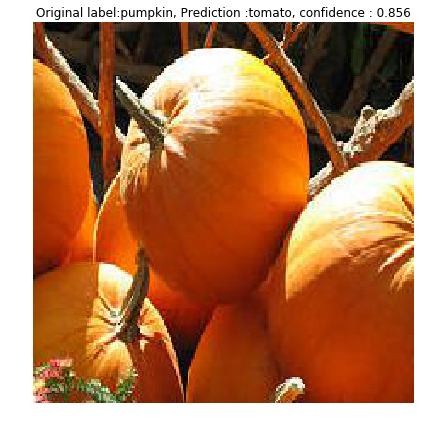

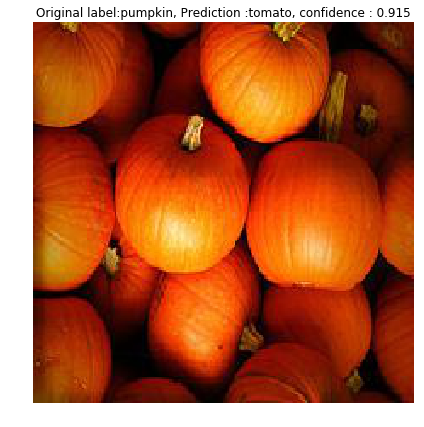

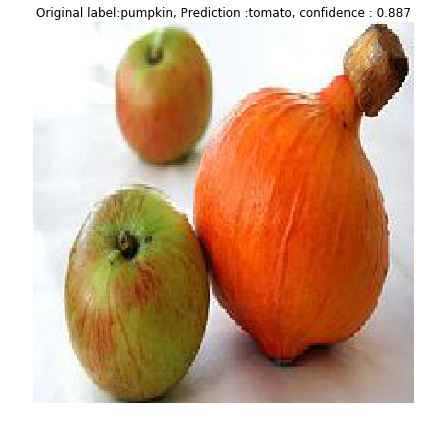

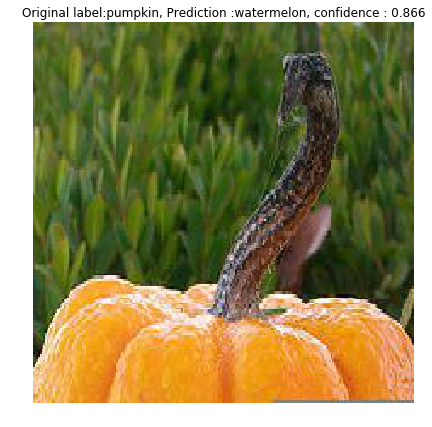

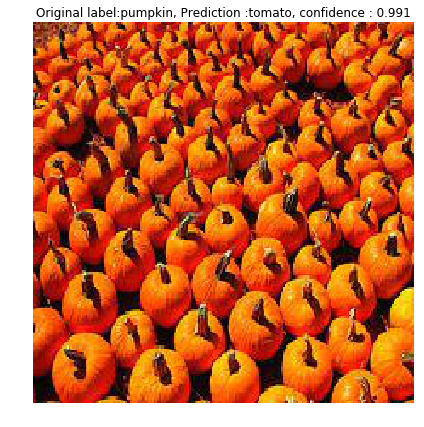

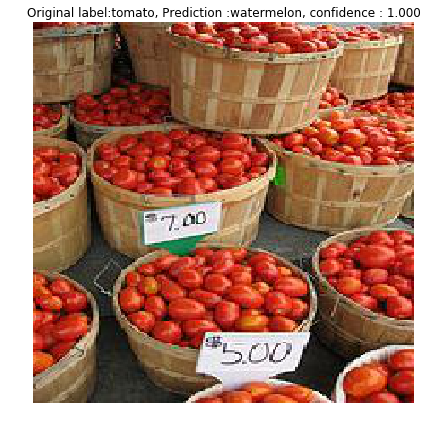

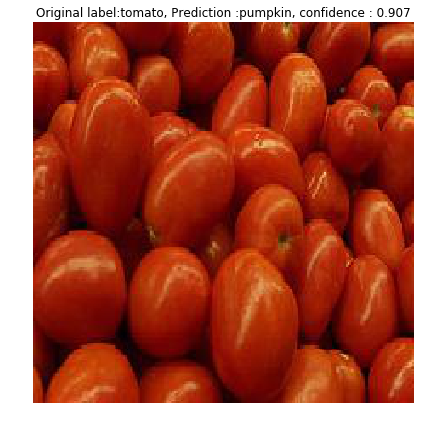

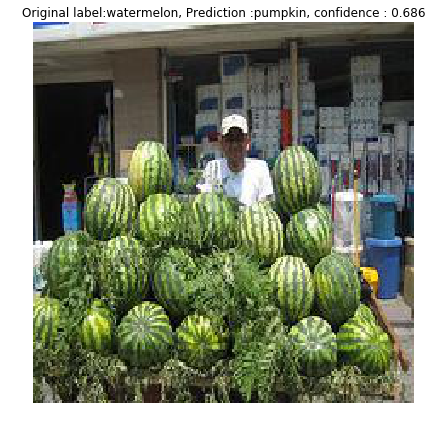

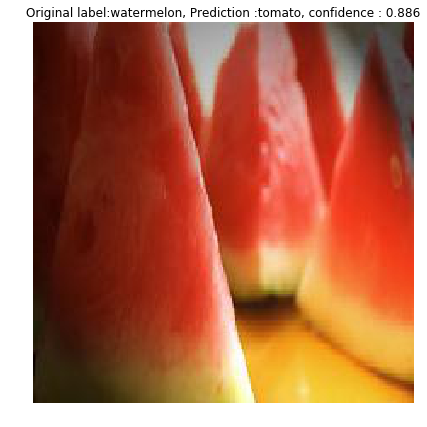

In [8]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

## Experiment 3 : Train last 4 layers with data augmentation


In [17]:
from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.engine.input_layer.InputLayer object at 0x7f864462f2b0> False
<keras.layers.convolutional.Conv2D object at 0x7f864462f320> False
<keras.layers.convolutional.Conv2D object at 0x7f864462f668> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86445f1438> False
<keras.layers.convolutional.Conv2D object at 0x7f86445feb70> False
<keras.layers.convolutional.Conv2D object at 0x7f8644602c88> False
<keras.layers.pooling.MaxPooling2D object at 0x7f8644607b70> False
<keras.layers.convolutional.Conv2D object at 0x7f8644594a20> False
<keras.layers.convolutional.Conv2D object at 0x7f864459a2b0> False
<keras.layers.convolutional.Conv2D object at 0x7f86445a15c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86445ab9e8> False
<keras.layers.convolutional.Conv2D object at 0x7f86445b68d0> False
<keras.layers.convolutional.Conv2D object at 0x7f86445b6f28> False
<keras.layers.convolutional.Conv2D object at 0x7f86445c2550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f86445ca7f0>

## Experiment 3
Train the model. Here we will be using the imageDataGenerator for data augmentation.

Found 100 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 25s 3s/step - loss: 0.6835 - acc: 0.6350 - val_loss: 0.3021 - val_acc: 1.0000
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.3523 - acc: 0.8450 - val_loss: 0.1311 - val_acc: 1.0000
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.2153 - acc: 0.9400 - val_loss: 0.0687 - val_acc: 1.0000
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 0.1256 - acc: 0.9750 - val_loss: 0.0412 - val_acc: 1.0000
Epoch 5/10
10/10 [==============================] - 20s 2s/step - loss: 0.0960 - acc: 0.9700 - val_loss: 0.0301 - val_acc: 1.0000
Epoch 6/10
10/10 [==============================] - 21s 2s/step - loss: 0.0758 - acc: 0.9800 - val_loss: 0.0242 - val_acc: 1.0000
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.0758 - acc: 0.9850 - val_loss: 0.0289 - val_acc: 1.0000
Epoch 8/1

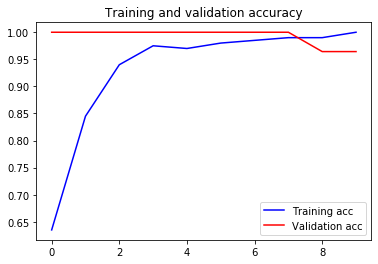

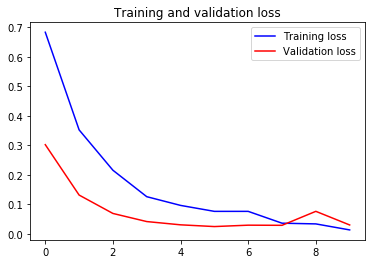

In [18]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

# Train the Model
# NOTE that we have multiplied the steps_per_epoch by 2. This is because we are using data augmentation.
history = model.fit_generator(
      train_generator,
      steps_per_epoch=2*train_generator.samples/train_generator.batch_size ,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the Model
model.save('da_last4_layers.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("da_last4_layers.json", "w") as json_file:
    json_file.write(model_json)

## Experiment 3
Show the errors

Found 150 images belonging to 3 classes.
15/15 [==============================] - 0s     
No of errors = 3/150


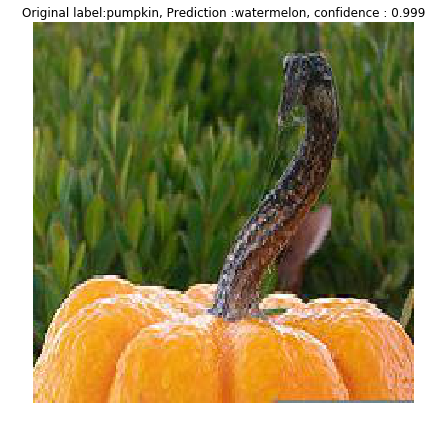

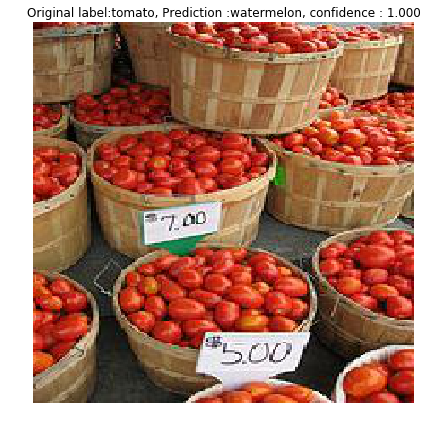

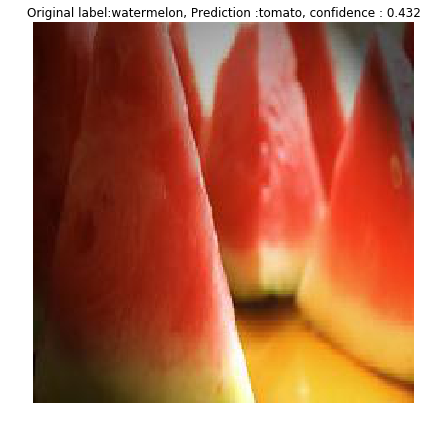

In [14]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [23]:
classify_model = load_model("/home/ubuntu/mayub/Github/learnopencv/Keras-Fine-Tuning/da_last4_layers.h5")

In [75]:
def prepare_image(img, im_type=None):
    if im_type=="classify":
        newsize = (224, 224) 
        img = img.resize(newsize) 
        
    #Load, normalize and return image 
    im = np.array(img)
    im = im/255.0
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225
    im = np.expand_dims(im,axis = 0)
    return im

In [113]:
# image = Image.open("/home/ubuntu/mayub/Github/Crowd_Detection/service/IMG_4.jpg")
image = Image.open("/home/ubuntu/CrowdSourcing_Projects/CSRNet-keras/data/Crowd Density Classification/test/dense/IMG_5.jpg")

In [114]:
image = prepare_image(image_copy,im_type="classify")

<class 'PIL.Image.Image'>
(1, 224, 224, 3)


In [116]:
predictions = classify_model.predict(image)
predictions

array([[0.00283422, 0.99716574]], dtype=float32)

In [117]:
predicted_classes = np.argmax(predictions,axis=1)


1

In [118]:
type(predicted_classes[0])

numpy.int64